### Python libraries

In [1]:
import os
import pandas as pd
import numpy as np
import copy as cp
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import scipy.stats as st
import joblib
import pickle
from numpy.random import seed
from tensorflow import set_random_seed
import matplotlib.pyplot as plt
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

Setting seed for the purpose of reproducible results.

In [2]:
seed(1)
set_random_seed(2)

### Custom libraries

In [3]:
from custom_utils import *

### Setting directories dedicated for raw and input data

In [4]:
HOME_DIR = os.getcwd()
DATA_RAW_DIR = os.path.join(HOME_DIR,'data_raw')
DATA_INPUT_DIR = os.path.join(HOME_DIR,'data_input')
MODELS_DIR = os.path.join(HOME_DIR,'models')
FIGURES_DIR = os.path.join(HOME_DIR,'figures')

### Uploading raw data

In [5]:
data = pd.read_csv(os.path.join(DATA_RAW_DIR,'Stroke_Prediction.csv'))
data.head()

ID  Gender  Age_In_Days  Hypertension  Heart_Disease Ever_Married  \
0  31153    Male       1104.0             0              0           No   
1  30650    Male      21204.0             1              0          Yes   
2  17412  Female       2928.0             0              0           No   
3  57008  Female      25578.0             0              0          Yes   
4  46657    Male       5128.0             0              0           No   

   Type_Of_Work Residence  Avg_Glucose   BMI   Smoking_Status  Stroke  
0      children     Rural        95.12  18.0              NaN       0  
1       Private     Urban        87.96  39.2     never smoked       0  
2       Private     Urban       110.89  17.6              NaN       0  
3       Private     Rural        69.04  35.9  formerly smoked       0  
4  Never_worked     Rural       161.28  19.1              NaN       0

In [6]:
data.shape

(43400, 12)

### Transforming column names

In [7]:
data.columns = [format_column_name(col) for col in data.columns]
data.head()

id  gender  age_in_days  hypertension  heart_disease ever_married  \
0  31153    Male       1104.0             0              0           No   
1  30650    Male      21204.0             1              0          Yes   
2  17412  Female       2928.0             0              0           No   
3  57008  Female      25578.0             0              0          Yes   
4  46657    Male       5128.0             0              0           No   

   type_of_work residence  avg_glucose   bmi   smoking_status  stroke  
0      children     Rural        95.12  18.0              NaN       0  
1       Private     Urban        87.96  39.2     never smoked       0  
2       Private     Urban       110.89  17.6              NaN       0  
3       Private     Rural        69.04  35.9  formerly smoked       0  
4  Never_worked     Rural       161.28  19.1              NaN       0

Stroke rate on entire population.

In [8]:
print(str(np.round(100*data.stroke.sum()/len(data),2))+'%')

1.8%


### Sample split

It needs to be highlighted that the preprocessing procedure needs to be done independently for train and test samples to properly verify the performance of models.

First, let's make a copy of data frame and set index on id.

In [9]:
df = cp.deepcopy(data)
df = df.set_index('id')
df.head()

gender  age_in_days  hypertension  heart_disease ever_married  \
id                                                                     
31153    Male       1104.0             0              0           No   
30650    Male      21204.0             1              0          Yes   
17412  Female       2928.0             0              0           No   
57008  Female      25578.0             0              0          Yes   
46657    Male       5128.0             0              0           No   

       type_of_work residence  avg_glucose   bmi   smoking_status  stroke  
id                                                                         
31153      children     Rural        95.12  18.0              NaN       0  
30650       Private     Urban        87.96  39.2     never smoked       0  
17412       Private     Urban       110.89  17.6              NaN       0  
57008       Private     Rural        69.04  35.9  formerly smoked       0  
46657  Never_worked     Rural       161.28  19.1              NaN       0

Separate explanatory variables (X) and response variable (y).

In [10]:
X = df.drop(columns=['stroke'])
y = df.stroke.values

Split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Preprocessing

First of all, I checked types of each columns.

In [12]:
df.dtypes

gender             object
age_in_days       float64
hypertension        int64
heart_disease       int64
ever_married       object
type_of_work       object
residence          object
avg_glucose       float64
bmi               float64
smoking_status     object
stroke              int64
dtype: object

Then, I checked, which column contains missing values.

In [13]:
find_missing_values(df)

null_occurrence  null_ratio     type
gender                    False        0.00   object
age_in_days               False        0.00  float64
hypertension              False        0.00    int64
heart_disease             False        0.00    int64
ever_married              False        0.00   object
type_of_work              False        0.00   object
residence                 False        0.00   object
avg_glucose               False        0.00  float64
bmi                        True        0.03  float64
smoking_status             True        0.31   object
stroke                    False        0.00    int64

Missing values imputation.

In [14]:
X_train = data_imputation(X_train, strategy_num='mean')
X_test = data_imputation(X_test, strategy_num='mean')

In [15]:
X_train.isna().any()

gender            False
age_in_days       False
hypertension      False
heart_disease     False
ever_married      False
type_of_work      False
residence         False
avg_glucose       False
bmi               False
smoking_status    False
dtype: bool

Transforming categorical variables into numerical ones using LabelEncoder from sklearn.

In [16]:
X_train = object_to_encode(X_train, value='NULL', verbose=True)
X_test = object_to_encode(X_test, value='NULL')

Variables transformed:

{'gender', 'residence', 'ever_married', 'smoking_status', 'type_of_work'}


In [17]:
X_train.dtypes

gender              int64
age_in_days       float64
hypertension        int64
heart_disease       int64
ever_married        int64
type_of_work        int64
residence           int64
avg_glucose       float64
bmi               float64
smoking_status      int64
dtype: object

### Saving preprocessed data.

In [18]:
X_train.to_pickle(os.path.join(DATA_INPUT_DIR,'X_train.pkl'))
X_test.to_pickle(os.path.join(DATA_INPUT_DIR,'X_test.pkl'))

In [19]:
with open(os.path.join(DATA_INPUT_DIR,'y_train.pkl'),'wb') as f:
    pickle.dump(y_train, f)

In [20]:
with open(os.path.join(DATA_INPUT_DIR,'y_test.pkl'),'wb') as f:
    pickle.dump(y_test, f)

### Uploading preprocessed data

In [21]:
X_train = pd.read_pickle(os.path.join(DATA_INPUT_DIR,'X_train.pkl'))
X_test = pd.read_pickle(os.path.join(DATA_INPUT_DIR,'X_test.pkl'))

In [22]:
with open(os.path.join(DATA_INPUT_DIR,'y_train.pkl'),'rb') as f_train:
    y_train = pickle.load(f_train)

In [23]:
with open(os.path.join(DATA_INPUT_DIR,'y_test.pkl'),'rb') as f_test:
    y_test = pickle.load(f_test)

### Creating data frames to hold predictions.

In [24]:
train = cp.deepcopy(X_train)
train['stroke'] = y_train

In [25]:
test = cp.deepcopy(X_test)
test['stroke'] = y_test

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

Fitting the Logistic Regression model.

In [27]:
with elapsed_time('Training the Logistic Regression model'):
    LR = LogisticRegression(penalty='l2', random_state=42, solver='lbfgs').fit(X_train, y_train)

Training the Logistic Regression model took: 0.23101353645324707


Saving the Logistic Regression model.

In [28]:
joblib.dump(LR, os.path.join(MODELS_DIR,'Logistic_Regression_model.pkl'))

['D:\\00_python_projects\\00_ATOS\\models\\Logistic_Regression_model.pkl']

Loading the Logistic Regression model.

In [29]:
LR = joblib.load(os.path.join(MODELS_DIR,'Logistic_Regression_model.pkl'))

Saving class and probability predictions on train and test samples. 

In [30]:
train['LR_class'] = LR.predict(X_train)
test['LR_class'] = LR.predict(X_test)

In [31]:
train['LR_predict_proba'] = pd.DataFrame(LR.predict_proba(X_train))[1].values
test['LR_predict_proba'] = pd.DataFrame(LR.predict_proba(X_test))[1].values

### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

Declaring space of hyperparameters.

In [34]:
params_dt = {'max_depth' : st.randint(4,10),
            'min_samples_split' : st.randint(25,100),
            'min_samples_leaf': st.randint(5,50)
            }

Optimization of Decision Tree hyperparameters using the randomized search method with corss-validation with 3 folds.

In [35]:
with elapsed_time('Optimization of Decision Tree hyperparameters'):
    DT_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=params_dt, n_iter=50, 
                   scoring='roc_auc', refit=True, cv=3, random_state=42).fit(X_train, y_train)

Optimization of Decision Tree hyperparameters took: 7.203412055969238


Best set of hyperparameters:

In [36]:
DT_search.best_params_

{'max_depth': 4, 'min_samples_leaf': 39, 'min_samples_split': 71}

Fitting the Decision Tree model.

In [37]:
with elapsed_time('Training the Decision Tree model'):
    DT = DecisionTreeClassifier(**DT_search.best_params_,random_state=42).fit(X_train, y_train)

Training the Decision Tree model took: 0.04100227355957031


Saving the Decision Tree model.

In [38]:
joblib.dump(DT, os.path.join(MODELS_DIR,'Decision_Tree_model.pkl'))

['D:\\00_python_projects\\00_ATOS\\models\\Decision_Tree_model.pkl']

Loading the Decision Tree model.

In [39]:
DT = joblib.load(os.path.join(MODELS_DIR,'Decision_Tree_model.pkl'))

Saving class and probability predictions on train and test samples.

In [40]:
train['DT_class'] = DT.predict(X_train)
test['DT_class'] = DT.predict(X_test)

In [41]:
train['DT_predict_proba'] = pd.DataFrame(DT.predict_proba(X_train))[1].values
test['DT_predict_proba'] = pd.DataFrame(DT.predict_proba(X_test))[1].values

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

Declaring space of hyperparameters.

In [44]:
params_rf = {'n_estimators' : st.randint(100,250),
            'max_depth' : st.randint(4,10),
            'min_samples_split' : st.randint(25,100),
            'min_samples_leaf': st.randint(5,50)
            }

Optimization of Random Forest hyperparameters using the randomized search method with corss-validation with 3 folds.

In [45]:
with elapsed_time('Optimization of Random Forest hyperparameters'):
    RF_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=params_rf, n_iter=50, 
                   scoring='roc_auc', refit=True, cv=3, random_state=42).fit(X_train, y_train)

Optimization of Random Forest hyperparameters took: 308.28163266181946


Best set of hyperparameters:

In [46]:
RF_search.best_params_

{'max_depth': 9,
 'min_samples_leaf': 48,
 'min_samples_split': 73,
 'n_estimators': 158}

Fitting the Random Forest model.

In [47]:
with elapsed_time('Training the Random Forest model'):
    RF = RandomForestClassifier(**RF_search.best_params_,random_state=42).fit(X_train, y_train)

Training the Random Forest model took: 2.505143404006958


Saving the Random Forest model.

In [48]:
joblib.dump(RF, os.path.join(MODELS_DIR,'Random_Forest_model.pkl'))

['D:\\00_python_projects\\00_ATOS\\models\\Random_Forest_model.pkl']

Loading the Random Forest model.

In [49]:
RF = joblib.load(os.path.join(MODELS_DIR,'Random_Forest_model.pkl'))

Saving class and probability predictions on train and test samples.

In [50]:
train['RF_class'] = RF.predict(X_train)
test['RF_class'] = RF.predict(X_test)

In [51]:
train['RF_predict_proba'] = pd.DataFrame(RF.predict_proba(X_train))[1].values
test['RF_predict_proba'] = pd.DataFrame(RF.predict_proba(X_test))[1].values

### Extreme Gradient Boosting (XGB)

In [53]:
from xgboost.sklearn import XGBClassifier

Declaring space of hyperparameters.

In [54]:
params_xgb = {'n_estimators' : st.randint(100,250),
            'max_depth' : st.randint(4,10),
            'learning_rate' : st.uniform(0.05,0.3),
            'subsample' : st.beta(5,1),
            'colsample_bytree' :  st.beta(5,1),
            'gamma' : st.uniform(0,10),
            'reg_alpha' : st.expon(0,50),
            'reg_lambda': st.expon(0,50),
            'min_child_weight' : st.randint(1,4)
            }

Optimization of Extreme Gradient Boosting hyperparameters using the randomized search method with corss-validation with 3 folds.

In [56]:
with elapsed_time('Optimization of Extreme Gradient Boosting parameters'):
    XGB_search = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=params_xgb, n_iter=50, 
                   scoring='roc_auc', refit=True, cv=3, random_state=42).fit(X_train, y_train)

Optimization of Extreme Gradient Boosting parameters took: 439.8071553707123


Best set of hyperparameters:

In [57]:
XGB_search.best_params_

{'colsample_bytree': 0.9023663867114847,
 'gamma': 9.568008851264564,
 'learning_rate': 0.25303097132729097,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 210,
 'reg_alpha': 4.347900440428258,
 'reg_lambda': 4.809256222055237,
 'subsample': 0.7206477334707789}

Fitting the Extreme Gradient Boosting model.

In [58]:
with elapsed_time('Training the Extreme Gradient Boosting model'):
    XGB = XGBClassifier(**XGB_search.best_params_,random_state=42).fit(X_train, y_train)

Training the Extreme Gradient Boosting model took: 8.57749080657959


Saving the Extreme Gradient Boosting model.

In [59]:
joblib.dump(XGB, os.path.join(MODELS_DIR,'Extreme_Gradient_Boosting_model.pkl'))

['D:\\00_python_projects\\00_ATOS\\models\\Extreme_Gradient_Boosting_model.pkl']

Loading the Extreme Gradient Boosting model.

In [60]:
XGB = joblib.load(os.path.join(MODELS_DIR,'Extreme_Gradient_Boosting_model.pkl'))

Saving class and probability predictions on train and test samples.

In [61]:
train['XGB_class'] = XGB.predict(X_train)
test['XGB_class'] = XGB.predict(X_test)

In [62]:
train['XGB_predict_proba'] = pd.DataFrame(XGB.predict_proba(X_train))[1].values
test['XGB_predict_proba'] = pd.DataFrame(XGB.predict_proba(X_test))[1].values

### Support Vector Machine (SVM)

In [64]:
from sklearn import svm

Fitting the Support Vector Machine model.

In [65]:
with elapsed_time('Training the SVM model'):
    SVM = svm.SVC(kernel='linear',probability=True, random_state=42).fit(X_train, y_train)

Training the SVM model took: 1053.4812557697296


Saving the Support Vector Machine model.

In [66]:
joblib.dump(SVM, os.path.join(MODELS_DIR,'Support_Vector_Machine_model.pkl'))

['D:\\00_python_projects\\00_ATOS\\models\\Support_Vector_Machine_model.pkl']

Loading the Support Vector Machine model.

In [67]:
SVM = joblib.load(os.path.join(MODELS_DIR,'Support_Vector_Machine_model.pkl'))

Saving class and probability predictions on train and test samples.

In [68]:
train['SVM_class'] = SVM.predict(X_train)
test['SVM_class'] = SVM.predict(X_test)

In [69]:
train['SVM_predict_proba'] = pd.DataFrame(SVM.predict_proba(X_train))[1].values
test['SVM_predict_proba'] = pd.DataFrame(SVM.predict_proba(X_test))[1].values

### Neural networks

In [47]:
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Creating simple Neural Network (architecture) based on sequential model with 2 hidden dense layers.

In [81]:
NN = Sequential()
#First Hidden Layer with 4 neurons
NN.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=10))
#Second  Hidden Layer with 2 neurons
NN.add(Dense(2, activation='relu', kernel_initializer='random_normal'))
#Output Layer
NN.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

Setting omptimizer, loss function and evaluate metric.

In [82]:
NN.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

Fitting the Neural Network.

In [83]:
with elapsed_time('Training the Neural Netowrk model'):
    NN.fit(X_train,y_train, batch_size=50, epochs=50, verbose=0, validation_split=0.2)

Training the Neural Netowrk model took: 19.62612271308899


Summary of obtained Neural Network.

In [84]:
NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


Saving the Neural Network model.

In [85]:
with open(os.path.join(MODELS_DIR,'Neural_Network_model.pkl'),'wb') as f:
    pickle.dump(NN,f)

Loading the Neural Network model.

In [86]:
with open(os.path.join(MODELS_DIR,'Neural_Network_model.pkl'),'rb') as f:
    NN = pickle.load(f)

Saving class and probability predictions on train and test samples.

In [87]:
train['NN_class'] = pd.DataFrame(NN.predict_classes(X_train))[0].values
test['NN_class'] = pd.DataFrame(NN.predict_classes(X_test))[0].values

In [88]:
train['NN_predict_proba'] = pd.DataFrame(NN.predict(X_train))[0].values
test['NN_predict_proba'] = pd.DataFrame(NN.predict(X_test))[0].values

### Saving results

In [90]:
train.to_pickle(os.path.join(DATA_INPUT_DIR,'train_all.pkl'))
test.to_pickle(os.path.join(DATA_INPUT_DIR,'test_all.pkl'))

### Uploading data frames with results

In [5]:
train = pd.read_pickle(os.path.join(DATA_INPUT_DIR,'train_all.pkl'))
test = pd.read_pickle(os.path.join(DATA_INPUT_DIR,'test_all.pkl'))

### Comparison

This section compares all of built models. Due to the small stroke rate on entire population I decided to calculate continous prediction (probability of getting stroke) to properly verify effectiveness of models.

In [6]:
model_labels = ['Logistic_Regression','Decision_Tree','Random_Forest','Extreme_Gradient_Boosting',
         'Support_Vector_Machine','Neural_Network']

In [7]:
col_indicator = ['LR','DT','RF', 'XGB','SVM','NN']

Comparison of performance of all considered models. The comparison is based on 4 measures: AUC (Area Under the Curve), Gini coefficient, accuracy based on confusion matrix and mean squared errors.

Firstly, I compared results on train sample.

In [8]:
compare_performance(train, 'stroke', col_indicator, model_labels)

AUC gini_ceofficient accuracy  \
Logistic_Regression        0.7163            43.3%    98.2%   
Decision_Tree              0.8580            71.6%    98.2%   
Random_Forest              0.9157            83.1%    98.2%   
Extreme_Gradient_Boosting  0.8734            74.7%    98.2%   
Support_Vector_Machine     0.7919            58.4%    98.2%   
Neural_Network             0.7220            44.4%    98.2%   

                           mean_squared_error  
Logistic_Regression                    0.0180  
Decision_Tree                          0.0168  
Random_Forest                          0.0163  
Extreme_Gradient_Boosting              0.0167  
Support_Vector_Machine                 0.0180  
Neural_Network                         0.0175

As we can see the highest performance corresponds to Random Forest model, however it can also be observed that all of tree-based models (Decision Tree, Random Forest and Extreme Gradient Boosting) are significantly better than other machine learning methods considered during this case study. The small number of records and small space of features is possible reason for that. The SVM and NN methods are usually used for larger datasets.
Last but not least, this comparison confirms the decision about comparing models based on continuous predictions (accuracy is the same for each models because all of the models classified all of the cases as 0 due to the small stroke rate equal to 1.8%).
Therefore, the main purpose is to find patients with the highest risk of getting stroke.

We have to keep in mind that the most valuable information about model performance is this calculated on independent test sample. 

In [9]:
compare_performance(test, 'stroke', col_indicator, model_labels)

AUC gini_ceofficient accuracy  \
Logistic_Regression        0.6877            37.5%    98.2%   
Decision_Tree              0.8297            65.9%    98.2%   
Random_Forest              0.8395            67.9%    98.2%   
Extreme_Gradient_Boosting  0.8454            69.1%    98.2%   
Support_Vector_Machine     0.7787            55.7%    98.2%   
Neural_Network             0.7082            41.6%    98.2%   

                           mean_squared_error  
Logistic_Regression                    0.0182  
Decision_Tree                          0.0173  
Random_Forest                          0.0171  
Extreme_Gradient_Boosting              0.0171  
Support_Vector_Machine                 0.0180  
Neural_Network                         0.0175

Based on above table we can see that in the case of test sample, the highest performance corresponds to Extreme Gradient Boosting model. It needs to be noted that similarly to train sample tree-based methods turned out to be statistically much better than other methods.  

To properly verify the effectiveness of mdoels we compared ROC curves for both train and test samples.

In [10]:
predict_proba_cols = ['LR_predict_proba','DT_predict_proba','RF_predict_proba',
                      'XGB_predict_proba','SVM_predict_proba','NN_predict_proba']

Train sample:

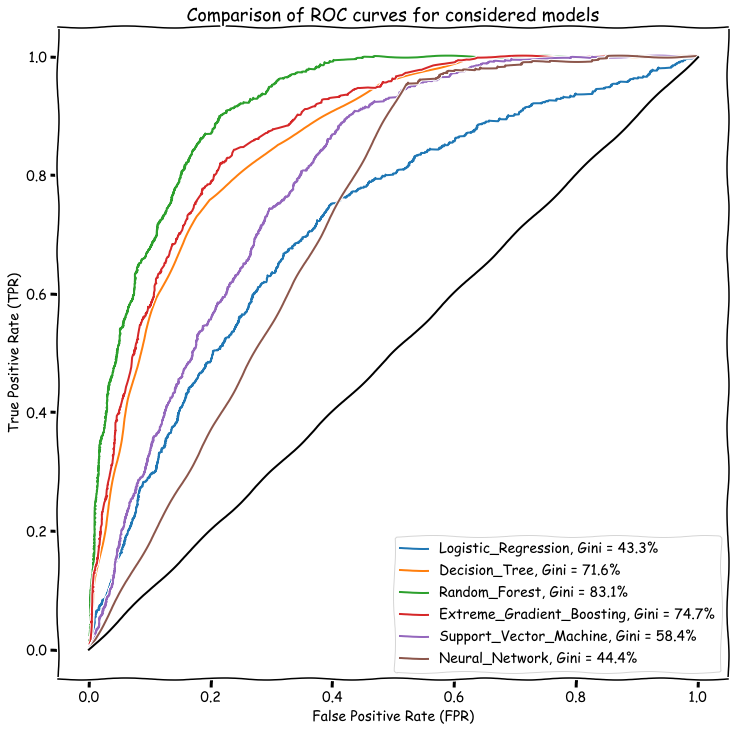

Figure saved in: D:\00_python_projects\00_ATOS\figures\train_roc_curves_all_models.png


<Figure size 432x288 with 0 Axes>

In [11]:
compare_roc_curves_for_single_sample(train, 'stroke', predict_proba_cols, 
                                     model_labels, save=True, loc=os.path.join(FIGURES_DIR,'train_roc_curves_all_models.png'))

Test sample:

In [12]:
compare_roc_curves_for_single_sample(test, 'stroke', predict_proba_cols, 
                                     model_labels, save=True, loc=os.path.join(FIGURES_DIR,'test_roc_curves_all_models.png'))

Figure saved in: D:\00_python_projects\00_ATOS\figures\test_roc_curves_all_models.png


<Figure size 432x288 with 0 Axes>

ROC curves confirmed conclusions from performance metrics comparison.

According to presented results, we decided to compare two best models, namely, Random Forest and Extreme Gradient Boosting on both train and test samples to choose the final model.

In [13]:
y_train = train.stroke.values
y_test = test.stroke.values

In [14]:
targets = [y_train, y_test, y_train, y_test]
preds = [train.XGB_predict_proba.values, test.XGB_predict_proba.values,
         train.RF_predict_proba.values, test.RF_predict_proba.values]
labels = ['Train: Extreme Gradient Boosting', 'Test: Extreme Gradient Boosting',
         'Train: Random Forest', 'Test: Random Forest']

In [15]:
compare_roc_curves_many_samples(targets, preds, labels, save=True, loc=os.path.join(FIGURES_DIR,'XGB_vs_RF.png'))

Figure saved in: D:\00_python_projects\00_ATOS\figures\XGB_vs_RF.png


<Figure size 432x288 with 0 Axes>

As we can see the Random Forest over-fitted to train sample even after the optimization of hyperparameters which included actions to prevent the event of over-fitting. The Extreme Gradient Boosting, as I mentioned before, has the highest performance on test sample and also significantly less decreses in predictive power between samples, which confirms stability of this model. 

To sumarize, I decided to choose Extreme Gradient Boosting model as a final and best one.

### Final model

Having the final XGBoost model I decided to check other statistical measures for verifing the effectiveness of the model. 

In [16]:
from scikitplot.metrics import plot_ks_statistic, plot_roc, plot_cumulative_gain, plot_lift_curve

Uploading the final model.

In [17]:
XGB = joblib.load(os.path.join(MODELS_DIR,'Extreme_Gradient_Boosting_model.pkl'))

Uploading X_test and y_test data.

In [18]:
X_test = pd.read_pickle(os.path.join(DATA_INPUT_DIR,'X_test.pkl'))
with open(os.path.join(DATA_INPUT_DIR,'y_test.pkl'),'rb') as f_test:
    y_test = pickle.load(f_test)

Making predictions of each class in target variable.

In [19]:
final_pred_proba = XGB.predict_proba(X_test)

##### ROC Curves for each class in target variable

In [20]:
plot_roc(y_test, final_pred_proba, title='ROC Curves for final XGBoost model', figsize=(12,8), 
         title_fontsize=20, text_fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR,'roc_curves_for_each_class_final_XGB.png'))

##### KS Statistic plot

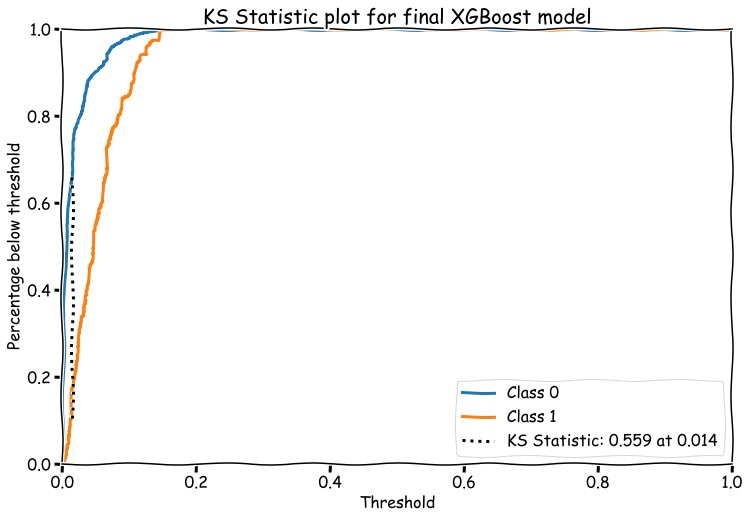

In [21]:
plot_ks_statistic(y_test, final_pred_proba, title='KS Statistic plot for final XGBoost model', figsize=(12,8), 
         title_fontsize=20, text_fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR,'ks_statistic_plot_for_final_XGB.png'))

Besides the high Gini coefficient equal to 69.1%, the final XGBoost model is characterized also by KS statistic equal to 55.9%, which is high predictive power according to relatively small stroke rate on entire population.

##### Cumulative Gain Curve

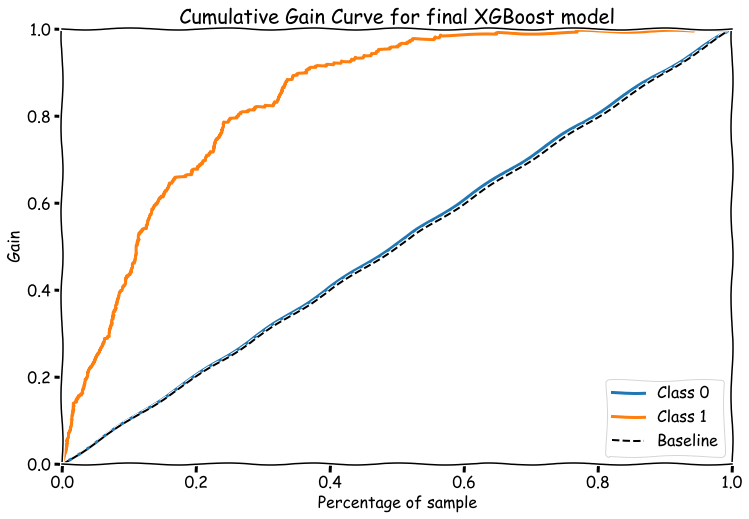

In [22]:
plot_cumulative_gain(y_test, final_pred_proba, title='Cumulative Gain Curve for final XGBoost model', figsize=(12,8), 
         title_fontsize=20, text_fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR,'cumulative_gain_curve_for_final_XGB.png'))

Cumulative gain plot shows that using the final XGBoost model we can properly detect 40% of all patients that will have stroke in the future by checking only 10% of all patients with the highest risk. Similarly, by checking 30% of petients with the hghest risk we can properly detect even 80% of patients.

##### Lift Curve

In [23]:
plot_lift_curve(y_test, final_pred_proba, title='Lift Curve for final XGBoost model', figsize=(12,8), 
         title_fontsize=20, text_fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR,'lift_curve_for_final_XGB.png'))

According to lift plot, by using the final XGBoost model we can properly detect 4 times more patients that will have stroke in the future than by no using no model. Similarly, by checking only 1% of population we are able to detect 10 times more patients.